In [ ]:
##
## get two cross-section measurements from HEPData and plot them
##
## e+ e- -> pi+ pi- BES-III 2016 https://www.hepdata.net/record/ins1385603
## e+ e- -> pi+ pi- CMD-2 2007 https://www.hepdata.net/record/ins728302
##
## gist -u c979808908344933d8162cfe5883628b precision-sm-kloe10-sep20.ipynb
## 

<!-- TEASER_END -->

In [2]:
from math import *
import re
from pprint import pprint
import urllib.request
from array import array
import json
import yaml
import itertools

import ROOT
from ROOT import TCanvas, TFile, TProfile, TNtuple, TH1F, TH2F, TLegend
from ROOT import TGraph, TGraphErrors, TGraphAsymmErrors
from ROOT import gROOT, gBenchmark, gRandom, gSystem, gStyle, gPad

Welcome to JupyROOT 6.22/00


In [4]:
##
## iterator generator using outer product of two lists
## - first list is inner and second one is outer
## - also able to return nth elements of iterator
## - iterator never ends but folds
##
class iterprod2:
  def __init__(self, arr1, arr2):
    self.arr1, self.arr2 = arr1, arr2
  def __iter__(self):
    self.i1 = 0
    self.i2 = 0
    return self
  def __next__(self):
    rc1, rc2 = self.arr1[self.i1], self.arr2[self.i2]
    self.i1 = (self.i1 + 1) % self.arr1.size()
    if (self.i1 == 0):
      self.i2 = (self.i2 + 1) % self.arr2.size()
    return rc1, rc2
  def elem(self, n):
    ielem1 = n % self.arr1.size()
    ielem2 = (n // self.arr1.size()) % self.arr2.size()
    return self.arr1[ielem1], self.arr2[ielem2]
  def elem1(self, n):
    return self.elem(n)[0]
  def elem2(self, n):
    return self.elem(n)[1]

In [5]:
##
## iterator generator using two lists with simultaneous advancement
## - also able to return nth elements of iterator
## - iterator never ends but folds
##
class iterzip2:
  def __init__(self, arr1, arr2):
    self.arr1, self.arr2 = arr1, arr2
  def __iter__(self):
    self.i1 = 0
    self.i2 = 0
    return self
  def __next__(self):
    rc1, rc2 = self.arr1[self.i1], self.arr2[self.i2]
    self.i1 = (self.i1 + 1) % self.arr1.size()
    self.i2 = (self.i2 + 1) % self.arr1.size()
    return rc1, rc2
  def elem(self, n):
    ielem1 = n % self.arr1.size()
    ielem2 = n % self.arr2.size()
    return self.arr1[ielem1], self.arr2[ielem2]
  def elem1(self, n):
    return self.elem(n)[0]
  def elem2(self, n):
    return self.elem(n)[1]

In [6]:
##
## from https://gist.github.com/gipert/df72b67c1d02bbb41f1dd406b6397811
##
cc_code = """\
/* paul_tol_colors.hpp
 *
 * Copyright (c) 2019 Luigi Pertoldi
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in all
 * copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
 * SOFTWARE.
 *
 * Author: Luigi Pertoldi - pertoldi@pd.infn.it
 * Created: 26 Sep 2019
 *
 * Implementation of Paul Tol's color palettes, as presented in
 *
 *   https://personal.sron.nl/~pault/data/colourschemes.pdf
 *
 * for the ROOT CERN software suite. Example usage:
 * ```
 * #include paul_tol_colors.hpp
 * using namespace tolcols;
 * void routine() {
 *   tolcols::init();
 *   hist->SetLineColor(kTVibBlue);
 * }
 * ```
 * Please read the technical note for a detailed explanation of the color palettes.
 */

#include "TColor.h"

#ifndef PAULTOLCOLORS_HPP
#define PAULTOLCOLORS_HPP

namespace tolcols {
    /*
     * Handy enum for later color referencing
     */
    enum {
        // Bright color scheme
        kTBriBlue        = 9000,
        kTBriCyan        = 9001,
        kTBriGreen       = 9002,
        kTBriYellow      = 9003,
        kTBriRed         = 9004,
        kTBriPurple      = 9005,
        kTBriGrey        = 9006,

        // Vibrant color scheme
        kTVibBlue        = 9007,
        kTVibCyan        = 9008,
        kTVibTeal        = 9009,
        kTVibOrange      = 9010,
        kTVibRed         = 9011,
        kTVibMagenta     = 9012,
        kTVibGrey        = 9013,

        // Muted color scheme
        kTMutIndigo      = 9014,
        kTMutCyan        = 9015,
        kTMutTeal        = 9016,
        kTMutGreen       = 9017,
        kTMutOlive       = 9018,
        kTMutSand        = 9019,
        kTMutRose        = 9020,
        kTMutWine        = 9021,
        kTMutPurple      = 9022,
        kTMutPaleGrey    = 9023,

        // Light color scheme
        kTLigLightBlue   = 9024,
        kTLigLightCyan   = 9025,
        kTLigMint        = 9026,
        kTLigPear        = 9027,
        kTLigOlive       = 9028,
        kTLigLightYellow = 9029,
        kTLigOrange      = 9030,
        kTLigPink        = 9031,
        kTLigPaleGrey    = 9032,

        // To label "bad" data (see BuRd and PRGn palettes below)
        kTBadData        = 9033
    };

    /* init()
     *
     * Define colors. Please call this function before doing anything
     */
    void init() {
        gStyle->SetColorModelPS(0);

        // Bright color scheme
        new TColor(kTBriBlue,         68./255, 119./255, 170./255, "tol-bri-blue"       );
        new TColor(kTBriCyan,        102./255, 204./255, 238./255, "tol-bri-cyan"       );
        new TColor(kTBriGreen,        34./255, 136./255,  51./255, "tol-bri-green"      );
        new TColor(kTBriYellow,      204./255, 187./255,  68./255, "tol-bri-yellow"     );
        new TColor(kTBriRed,         238./255, 102./255, 119./255, "tol-bri-red"        );
        new TColor(kTBriPurple,      170./255,  51./255, 119./255, "tol-bri-purple"     );
        new TColor(kTBriGrey,        187./255, 187./255, 187./255, "tol-bri-grey"       );

        // Vibrant color scheme
        new TColor(kTVibBlue,          0./255, 119./255, 187./255, "tol-vib-blue"       );
        new TColor(kTVibCyan,         51./255, 187./255, 238./255, "tol-vib-cyan"       );
        new TColor(kTVibTeal,          0./255, 153./255, 136./255, "tol-vib-teal"       );
        new TColor(kTVibOrange,      238./255, 119./255,  51./255, "tol-vib-orange"     );
        new TColor(kTVibRed,         204./255,  51./255,  17./255, "tol-vib-red"        );
        new TColor(kTVibMagenta,     238./255,  51./255, 119./255, "tol-vib-magenta"    );
        new TColor(kTVibGrey,        187./255, 187./255, 187./255, "tol-vib-grey"       );

        // Muted color scheme
        new TColor(kTMutIndigo,       51./255,  34./255, 136./255, "tol-mut-indigo"     );
        new TColor(kTMutCyan,        136./255, 204./255, 238./255, "tol-mut-cyan"       );
        new TColor(kTMutTeal,         68./255, 170./255, 153./255, "tol-mut-teal"       );
        new TColor(kTMutGreen,        17./255, 119./255,  51./255, "tol-mut-green"      );
        new TColor(kTMutOlive,       153./255, 153./255,  51./255, "tol-mut-olive"      );
        new TColor(kTMutSand,        221./255, 204./255, 119./255, "tol-mut-sand"       );
        new TColor(kTMutRose,        204./255, 102./255, 119./255, "tol-mut-rose"       );
        new TColor(kTMutWine,        136./255,  34./255,  85./255, "tol-mut-wine"       );
        new TColor(kTMutPurple,      170./255,  68./255, 153./255, "tol-mut-purple"     );
        new TColor(kTMutPaleGrey,    221./255, 221./255, 221./255, "tol-mut-palegrey"   );

        // Light color scheme
        new TColor(kTLigLightBlue,   119./255, 170./255, 221./255, "tol-lig-lightblue"  );
        new TColor(kTLigLightCyan,   153./255, 221./255, 255./255, "tol-lig-lightcyan"  );
        new TColor(kTLigMint,         68./255, 187./255, 153./255, "tol-lig-mint"       );
        new TColor(kTLigPear,        187./255, 204./255,  51./255, "tol-lig-pear"       );
        new TColor(kTLigOlive,       170./255, 170./255,   0./255, "tol-lig-olive"      );
        new TColor(kTLigLightYellow, 238./255, 221./255, 136./255, "tol-lig-lightyellow");
        new TColor(kTLigOrange,      238./255, 136./255, 102./255, "tol-lig-orange"     );
        new TColor(kTLigPink,        255./255, 170./255, 187./255, "tol-lig-pink"       );
        new TColor(kTLigPaleGrey,    221./255, 221./255, 221./255, "tol-lig-palegrey"   );

        new TColor(kTBadData,        255./255, 238./255, 153./255, "tol-bad-data"       );
    }

    /* set_sunset_palette
     *
     * Set sunset diverging colour scheme as the default palette
     * `ncols` specifies how many colors the palette should contain
     *
     * Use `kWhite` to label "bad" data
     */
    void set_sunset_palette(int ncols = 50) {
        double R[11] = { 54./255,  74./255, 110./255, 152./255, 194./255, 234./255, 254./255, 253./255, 246./255, 221./255, 165./255};
        double G[11] = { 75./255, 123./255, 166./255, 202./255, 228./255, 236./255, 218./255, 179./255, 126./255,  61./255,   0./255};
        double B[11] = {154./255, 183./255, 205./255, 225./255, 239./255, 204./255, 139./255, 102./255,  75./255,  45./255,  38./255};
        double l[11] = {     0.0,      0.1,      0.2,      0.3,      0.4,      0.5,      0.6,      0.7,      0.8,      0.9,      1.0};
        TColor::CreateGradientColorTable(11, l, R, G, B, ncols);
    }

    /* set_burd_palette
     *
     * Set BuRd diverging colour scheme as the default palette
     * `ncols` specifies how many colors the palette should contain
     *
     * Use `kTBadData` to label "bad" data
     */
    void set_burd_palette(int ncols = 50) {
        double R[9] = { 33./255,  67./255, 146./255, 209./255, 247./255, 253./255, 244./255, 214./255, 178./255};
        double G[9] = {102./255, 147./255, 197./255, 229./255, 247./255, 219./255, 165./255,  96./255,  24./255};
        double B[9] = {172./255, 195./255, 222./255, 240./255, 247./255, 199./255, 130./255,  77./255,  43./255};
        double l[9] = {   0.000,    0.125,    0.250,    0.375,    0.500,    0.625,    0.750,    0.875,    1.000};
        TColor::CreateGradientColorTable(11, l, R, G, B, ncols);
    }

    /* set_prgn_palette
     *
     * Set PRGn diverging colour scheme as the default palette
     * `ncols` specifies how many colors the palette should contain
     *
     * Use `kTBadData` to label "bad" data
     */
    void set_prgn_palette(int ncols = 50) {
        double R[9] = {118./255, 153./255, 194./255, 231./255, 247./255, 217./255, 172./255,  90./255,  27./255};
        double G[9] = { 42./255, 112./255, 165./255, 212./255, 247./255, 240./255, 211./255, 174./255, 120./255};
        double B[9] = {131./255, 171./255, 207./255, 232./255, 247./255, 211./255, 158./255,  97./255,  55./255};
        double l[9] = {   0.000,    0.125,    0.250,    0.375,    0.500,    0.625,    0.750,    0.875,    1.000};
        TColor::CreateGradientColorTable(11, l, R, G, B, ncols);
    }
};

#endif
"""
with open("paul_tol_colors.hh", "wt") as text_file:
  print(cc_code, file=text_file)

In [7]:
##
## setup lists of colors, line styles, marker styles
##
cc_code = """\
#include "paul_tol_colors.hh"

namespace tolcols {
  const std::vector<int> mutedcols = {
    kTMutIndigo      ,
    kTMutCyan        ,
    kTMutTeal        ,
    kTMutGreen       ,
    kTMutOlive       ,
    kTMutSand        ,
    kTMutRose        ,
    kTMutWine        ,
    kTMutPurple
  };
  const int mutedcol_invalid = kTMutPaleGrey;
  
  const std::vector<int> linestyles = {
    kSolid      ,
    kDashed     ,
    kDotted     ,
    kDashDotted
  };
  
  const std::vector<int> vibrantcols = {
    kTVibBlue,
    kTVibCyan,
    kTVibTeal,
    kTVibOrange,
    kTVibRed,
    kTVibMagenta,
    kTVibGrey
  };
  
  const std::vector<int> markerstyles = {
    kFullCircle,
    kFullSquare,
    kFullTriangleUp,
    kFullTriangleDown,
    kFullStar,
    kFullDiamond,
    kFullCross,
    kFullThreeTriangles,
    kFullFourTrianglesX,
    kFullDoubleDiamond,
    kFullFourTrianglesPlus,
    kFullCrossX
    // kFourSquaresX,
    // kFourSquaresPlus,
  };
}
"""
ROOT.gInterpreter.ProcessLine(cc_code)
ROOT.tolcols.init()

col_lstyle_gen = iterprod2(ROOT.tolcols.mutedcols, ROOT.tolcols.linestyles)
col_lstyle_iter = iter(col_lstyle_gen)

mstyle_col_gen = iterzip2(ROOT.tolcols.markerstyles, ROOT.tolcols.vibrantcols)
mstyle_col_iter = iter(mstyle_col_gen)

In [8]:
##
## functions and defs
##

In [9]:
def json_load_url(url):
  return json.load(urllib.request.urlopen(url))

def yaml_load_url(url):
  return yaml.safe_load(urllib.request.urlopen(url))

In [10]:
##
## get symmetric unc
## if multiple unc are present, get quadratic sum
## handle case when unc is specified as percent of value
##
def get_symm_unc(uncvec, yval=0):
  vvar = 0
  for cunc in uncvec:
    vunc = cunc["symerror"]
    if (type(vunc) in (int, float)):
      vvar += cunc["symerror"]**2
    else:
      ##--- handle syst unc defined as percent of yval
      ## rc = re.match(r"^([^%]*)%$", vunc)
      rc = get_symm_unc.re_percunc.match(vunc)
      if (rc != None):
        vunc = float(rc.groups()[0])
        vvar += (vunc/100 * yval)**2
  return sqrt(vvar)
##--- precompile regexp
get_symm_unc.re_percunc = re.compile(r"^([^%]*)%$")

In [11]:
##
## code
##

In [12]:
canvas = TCanvas("canvas", "canvas", 800, 600)
gPad.SetTopMargin(0.10)
gPad.SetBottomMargin(0.10)
gPad.SetLeftMargin(0.10)
gPad.SetRightMargin(0.10)

In [13]:
##
## BES-III
##
ins1385603_entry = json_load_url("https://www.hepdata.net/record/ins1385603?format=json")
print("Last updated: ", ins1385603_entry["record"]["last_updated"])
pprint(ins1385603_entry)

Last updated:  Fri, 19 Aug 2016 15:10:42 GMT
{'access_count': {'sum': 710},
 'additional_resources': True,
 'breadcrumb_text': 'Ablikim, M. et al.',
 'coordinator': 1,
 'data_tables': [{'data': {'csv': 'https://www.hepdata.net/download/table/ins1385603/Table1/csv',
                           'json': 'https://www.hepdata.net/download/table/ins1385603/Table1/json',
                           'root': 'https://www.hepdata.net/download/table/ins1385603/Table1/root',
                           'yaml': 'https://www.hepdata.net/download/table/ins1385603/Table1/yaml',
                           'yoda': 'https://www.hepdata.net/download/table/ins1385603/Table1/yoda'},
                  'description': 'Results of the BESIII measurement of the '
                                 'cross section $\\sigma^{\\rm '
                                 'bare}_{\\pi^+\\pi^-(\\gamma_{\\rm FSR})} '
                                 '\\equiv \\sigma^{\\rm '
                                 'bare}(e^+e^-\\rightarr

In [14]:
##
## CMD-2
##
ins728302_entry = json_load_url("https://www.hepdata.net/record/ins728302?format=json")
print("Last updated: ", ins728302_entry["record"]["last_updated"])
pprint(ins728302_entry)

Last updated:  Tue, 10 Oct 2006 00:00:00 GMT
{'access_count': {'sum': 882},
 'additional_resources': True,
 'breadcrumb_text': 'Akhmetshin, R.R. et al.',
 'coordinator': 1,
 'data_tables': [{'data': {'csv': 'https://www.hepdata.net/download/table/ins728302/Table1/csv',
                           'json': 'https://www.hepdata.net/download/table/ins728302/Table1/json',
                           'root': 'https://www.hepdata.net/download/table/ins728302/Table1/root',
                           'yaml': 'https://www.hepdata.net/download/table/ins728302/Table1/yaml',
                           'yoda': 'https://www.hepdata.net/download/table/ins728302/Table1/yoda'},
                  'description': 'Measured values of the pion form factor. The '
                                 'errors are statistical only.',
                  'doi': '10.17182/hepdata.41782.v1/t1',
                  'id': 35960,
                  'location': 'Data from T 2,F 9',
                  'messages': False,
           

In [15]:
gStyle.SetOptStat(0)
basehist = TH1F("basehist", "|F_{#pi}|^{2}", 100, 0.5, 1)
basehist.SetMinimum(0)
basehist.SetMaximum(55)
basehist.GetXaxis().SetTitle("#sqrt{s} [GeV]")
basehist.GetYaxis().SetTitle("|F_{#pi}|^{2}")

basehist.Draw("")
## canvas.Draw()

In [16]:
##
## get YAML of first item of the submission
##
ins1385603_Table1 = yaml_load_url(ins1385603_entry["data_tables"][0]["data"]["yaml"])

##
## independent variable
##
xval = array('f')
for ielem, delem in enumerate(ins1385603_Table1["independent_variables"][0]["values"]):
  xval.append(delem["value"]/1000)

##
## 2nd dependent variable, pion form factor
##
yval = array('f')
yunc = array('f')
for ielem, delem in enumerate(ins1385603_Table1["dependent_variables"][1]["values"]):
  yvalcurr = delem["value"]
  yval.append(yvalcurr)
  yunc.append(get_symm_unc(delem["errors"], yvalcurr))

##
## TGraphErrors
##
ins1385603_gr = TGraphErrors(len(xval), xval, yval, 0, yunc)
title = "-".join(ins1385603_entry["record"]["collaborations"])
title += " " + ins1385603_entry["record"]["year"]
ins1385603_gr.SetTitle(title)
mstyle, col = next(mstyle_col_iter)
ins1385603_gr.SetMarkerStyle( mstyle )
ins1385603_gr.SetLineColor( col )
ins1385603_gr.SetMarkerColor( col )

ins1385603_gr.Draw("epsame")
## canvas.Draw()

In [17]:
##
## get YAML of first item of the submission
##
ins728302_Table1 = yaml_load_url(ins728302_entry["data_tables"][0]["data"]["yaml"])

##
## independent variable
##
xval = array('f')
for ielem, delem in enumerate(ins728302_Table1["independent_variables"][0]["values"]):
  xval.append(delem["value"]/1000)

##
## 1st dependent variable, pion form factor
##
yval = array('f')
yunc = array('f')
for ielem, delem in enumerate(ins728302_Table1["dependent_variables"][0]["values"]):
  yvalcurr = delem["value"]
  yval.append(yvalcurr)
  yunc.append(get_symm_unc(delem["errors"], yvalcurr))

##
## TGraphErrors
##
ins728302_gr = TGraphErrors(len(xval), xval, yval, 0, yunc)
title = "-".join(ins728302_entry["record"]["collaborations"])
title += " " + ins728302_entry["record"]["year"]
ins728302_gr.SetTitle(title)
mstyle, col = next(mstyle_col_iter)
ins728302_gr.SetMarkerStyle( mstyle )
ins728302_gr.SetLineColor( col )
ins728302_gr.SetMarkerColor( col )

ins728302_gr.Draw("epsame")
## canvas.Draw()

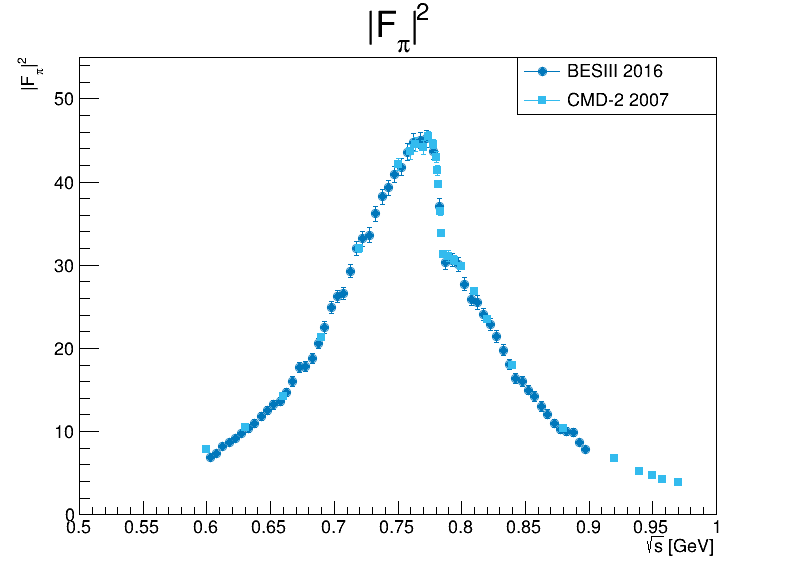

In [18]:
leg = TLegend(0.65, 0.80, 0.90, 0.90)
leg.SetTextSize(0.035)
leg.AddEntry(ins1385603_gr, ins1385603_gr.GetTitle(), "LP")
leg.AddEntry(ins728302_gr, ins728302_gr.GetTitle(), "LP")
leg.Draw()
canvas.Draw()

In [19]:
rfile = TFile("precision-sm-pip-pim.root", "recreate")
canvas.Write("pip-pim")
rfile.Close()